### Lab Machine Learning, part one: Heart disease prediction.
#### Daniel Claesson, ITHS, AI-23
[Link Kaggle dataset](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset)  
Features in the dataset:  
Age (days), Height (cm), Weight (kg), Gender; 1 = woman, 2 = man, Systolic blood pressure: ap_hi, Diastolic blood pressure: ap_lo, Cholesterol: (1: normal, 2: above normal, 3: well above normal),  
Glucose: (1: normal, 2: above normal, 3: well above normal), Smoking: binary, Alcohol: binary, Physical activity: binary, Presence or absence of cardiovascular disease 'cardio': binary

#### Introduction:
- Dataset contains data on body measures and different lifestyle factors, as well as wether the individual is diagnosed with cardiovascular disease or not (='cardio').
- The aim is to develop a model for predicting 'cardio', e.g. presence or absence of cardiovascular disease. This means that cardio is the response variable and the other features, such as body measures and lifestyle factors, are explanatory variables.
- This is a classification problem.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_orig = pd.read_csv('../data/cardio_train.csv', delimiter=";")
df_orig.drop(columns=['id'], inplace=True)
df = df_orig # create a copy of read in data. df_orig used as reference.

#### Method:
- EDA is performed to gain an understanding of the dataset.
- Feature Engineering is performed to remove unrealistic data, data pruning, identifying feature that correlate with 'cardio', remove data that has low correlation with 'cardio' or features that have high correlation between themselves (to avoid colinearity / multicolinearity).
- Classification using different Machine Learning algorithms.

#### EDA, Exploratory Data Analysis:

In [27]:
df.head(1)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0


There is 70000 mumber of individuals in the dataset.
The number of females is 45530 and the number of males is 24470.
Age [years]: Mean=53.3, Stdev=6.8, Min=29.6, Max=65.0 
Ratio of individuals that smoke: 8.8%
The percentage of individuals with "above normal" (2) or "well above normal cholesterol" (3) is 25.2%
The percentage of individuals that drink alcohol is 5.4%


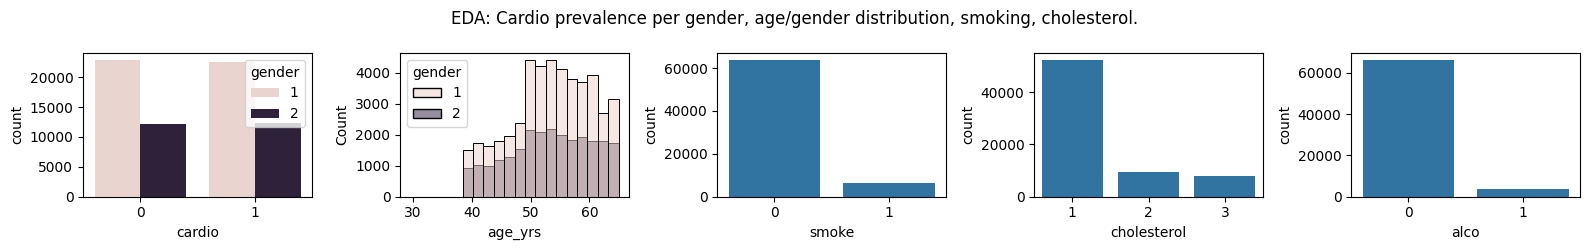

In [28]:
df.loc[:,'age_yrs'] = round(df.loc[:,'age']/365,2) # converting age in days into age in years
print(f'There is {len(df)} mumber of individuals in the dataset.')
print(f'The number of females is {len(df[df["gender"] == 1])} and the number of males is {len(df[df["gender"] == 2])}.')
print(f"Age [years]: Mean={df['age_yrs'].mean():.1f}, Stdev={df['age_yrs'].std():.1f}, Min={df['age_yrs'].min():.1f}, Max={df['age_yrs'].max():.1f} ")
print(f"Ratio of individuals that smoke: {df['smoke'][df['smoke'] == 1].sum() / len(df['smoke']):.1%}")
print(f'The percentage of individuals with "above normal" (2) or "well above normal cholesterol" (3) is {((len(df[df["cholesterol"] == 2]) + len(df[df["cholesterol"] == 3])) / len(df)):.1%}')
print(f'The percentage of individuals that drink alcohol is {len(df[df["alco"] == 1]) / len(df):.1%}')

fig, ax = plt.subplots(1, 5, figsize=(16,2.5))
plt.suptitle('EDA: Cardio prevalence per gender, age/gender distribution, smoking, cholesterol.')
sns.countplot(data=df, x='cardio', hue='gender',ax=ax[0])
sns.histplot(data = df, x='age_yrs', bins=20, hue='gender', ax=ax[1])
sns.countplot(data=df, x='smoke', ax=ax[2])
sns.countplot(df, x='cholesterol', ax=ax[3])
sns.countplot(df, x='alco', ax=ax[4])
plt.tight_layout()

Weight, height and blood pressure distributions.
- Analysis of weight, height and blood pressure data reveals that there are unrealistic data in the dataset.
- For weight and heigth, there is data primarilly in the lower end that is unrealistic.
- Blood pressure data: there are unrealistic data that are either too low or even negative, as well as data that is way too high. The unit is mmHg, and my own basic knowledge is that values ranging from 60 to 140 is common among healthy individuals. High blood pressure is probably in the area of around 200+ mmHg. Theory and further discussion in the Feature Engineering part below.
- The unrealistic data is handled in Feature Engineering below.
- Correlation Matrix on the data "as is" does not reveal much interesting insights. Feature Engineering needs to be done first.

height: mean=164.36, stdev=8.21, min=55.00, max=250.00 
weight: mean=74.21, stdev=14.40, min=10.00, max=200.00 
ap_hi: mean=128.82, stdev=154.01, min=-150.00, max=16020.00 
ap_lo: mean=96.63, stdev=188.47, min=-70.00, max=11000.00 


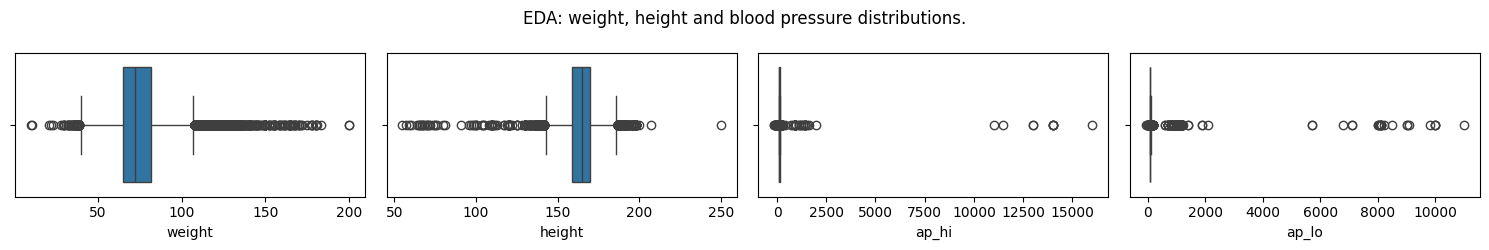

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(15,2.5))
fig.suptitle('EDA: weight, height and blood pressure distributions.')
sns.boxplot(data=df, x='weight', ax=ax[0])
sns.boxplot(data=df, x='height', ax=ax[1])
sns.boxplot(data=df, x='ap_hi', ax=ax[2])
sns.boxplot(data=df, x='ap_lo', ax=ax[3])
#sns.countplot(data=df, x='cardio', hue='gender', ax=[1,0])
for item in ['height','weight','ap_hi','ap_lo']:
    print(f"{item}: mean={df[item].mean():.2f}, stdev={df[item].std():.2f}, min={df[item].min():.2f}, max={df[item].max():.2f} ")
plt.tight_layout()

### Feature engineering:
- Handle the unrealistic data in the dataset.
- Identify features to be included in analysis of predicting cardiovacular disease.
#### Weight and Height
- Removing unrealistic data on weight and height, based on BMI. Involves the steps of calculating BMI for each individual. Theory from [Wikipedia article](https://en.wikipedia.org/wiki/Body_mass_index) used to define thresholds for removing data.
- Analysis of BMI in the dataset shows that BMI below the area of 14 is very "unlikely", can be regarded as outliers. At around BMI=14, the "bell curve" starts. Therefore, BMI<14 are removed.
- In the high end of BMI, no data is removed, beacuse it's still realistic to weight 200+kg.
- Pruning: After above removing of samples based on BMI, an analysis shows that there are still samples in the dataset (on the low end) that could be considered 'strange', e.g. 28kg and 128 cm tall, which is very odd for adults. In an attempt to remove such data, decision was made to remove samples that deviate more than 2.5 standard deviations from mean (on the low end only), for either height or weight. This means that samples with weight less than approximately 36kg and height less than 145 cm are removed.
#### Blood Pressure
- Blood pressure is measured in mmHg. The article [Link to heart.org](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings) states that ap_hi below 120 and ap_lo below 80 is healthy. ap_hi above 180 and ap_lo above 120 is hypertension crisis. The scale ends there, not stating what max level is realistic. Analysis of the data, in combination with information from the article, indicates that a good approximation should be to keep values for (50 < ap_hi < 250) and (40 < ap_lo < 200).

In [30]:
df['BMI'] = round(df['weight']/(df['height']/100)**2,2) #calculation of BMI, added to df
weight_info = df['weight'].describe() # creating an object that contains statistical data on weight, used for pruning
weight_low = weight_info['50%'] - 2.5 * weight_info['std'] # calculating the lower level of weight, values below to be removed
height_info = df['height'].describe() # creating an object that contains statistical data on height, used for pruning
height_low = height_info['50%'] - 2.5 * height_info['std'] # calculating the lower level of height, values below to be removed
df = df[(df['ap_lo'] < 200) & (df['ap_lo'] > 40) & (df['ap_hi'] > 50) & (df['ap_hi'] < 250) & (df['BMI'] >= 14) & (df['weight'] > weight_low) & (df['height'] > height_low)] #pruning and removal

#### Results from Feature Engineering:

height data: Mean=164.53, Stdev=7.72, Min=145.00, Max=207.00 
weight data: Mean=74.16, Stdev=14.25, Min=37.00, Max=200.00 
BMI data: Mean=27.43, Stdev=5.17, Min=14.48, Max=68.31 
ap_hi data: Mean=126.61, Stdev=16.75, Min=70.00, Max=240.00 
ap_lo data: Mean=81.40, Stdev=9.66, Min=45.00, Max=190.00 
Removing unrealistic data (due to BMI, height, weight and Blood Pressure) removed 1619 instances of the sampled data


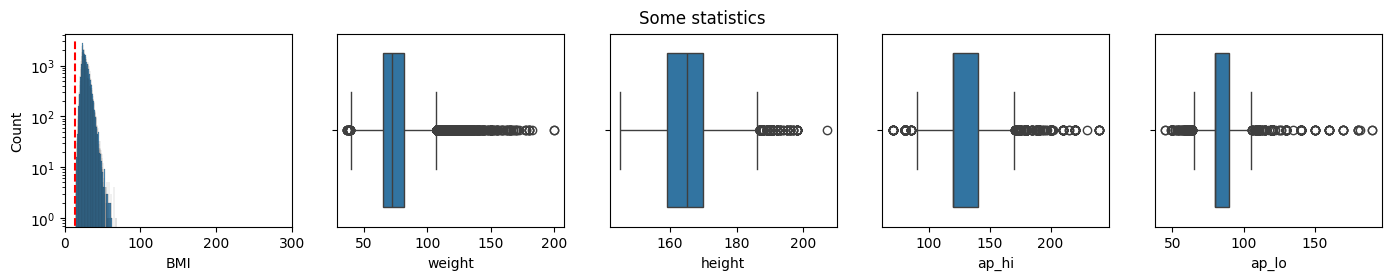

In [31]:
fig, ax = plt.subplots(1, 5, figsize=(17,2.5))
sns.histplot(data=df, x='BMI', cumulative=False, ax=ax[0])
fig.suptitle('Some statistics')
ax[0].set_xlim(right=300, left=0)
ax[0].set_yscale('log')
line_1 = plt.Line2D(xdata=[14,14], ydata=[0,3000], linestyle='--', color='red')
#line_2 = plt.Line2D(xdata=[200,200], ydata=[0,3000], linestyle='--', color='red')
ax[0].add_line(line_1)
#ax[0].add_line(line_2)
sns.boxplot(data=df, x='weight', ax=ax[1])
sns.boxplot(data=df, x='height', ax=ax[2])
sns.boxplot(data=df, x='ap_hi', ax=ax[3])
sns.boxplot(data=df, x='ap_lo', ax=ax[4])
for item in ['height','weight','BMI','ap_hi','ap_lo']:
    print(f"{item} data: Mean={df[item].mean():.2f}, Stdev={df[item].std():.2f}, Min={df[item].min():.2f}, Max={df[item].max():.2f} ")
print(f'Removing unrealistic data (due to BMI, height, weight and Blood Pressure) removed {len(df_orig)-len(df)} instances of the sampled data')

C:\Users\danie\AppData\Local\Temp\ipykernel_19316\867523421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if 'age_yrs' in df.columns: df.drop(columns=['age_yrs'], inplace=True)


<Axes: >

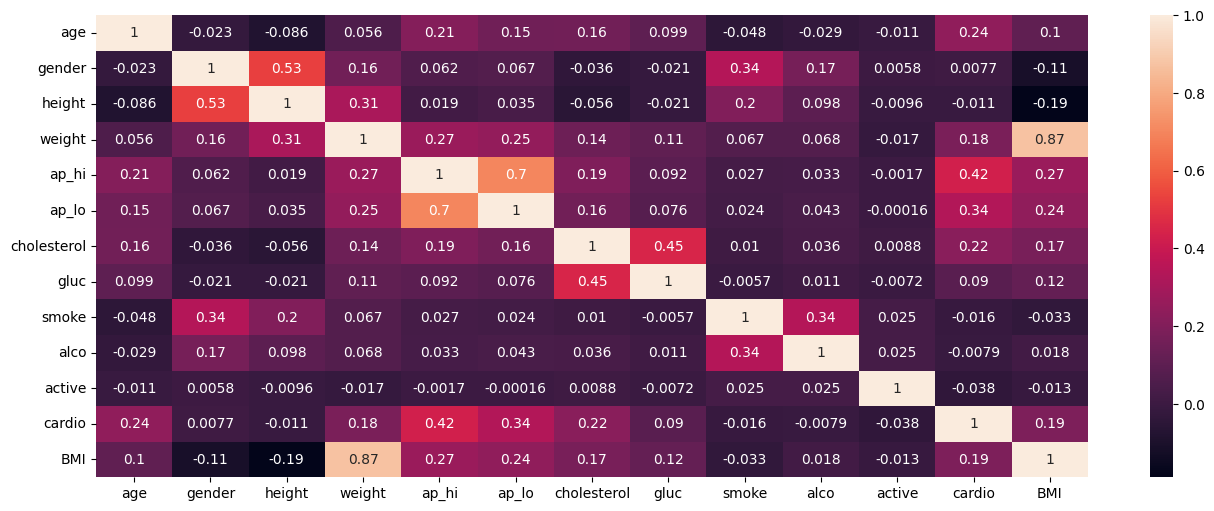

In [32]:
if 'age_yrs' in df.columns: df.drop(columns=['age_yrs'], inplace=True)
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(16,6))
sns.heatmap(df_corr, annot=True)

In [33]:
# Listing top correlations between 'cardio' and the other features, in descending order.
a_corr = df_corr['cardio'].abs().sort_values(ascending=False)
print(a_corr[1:15])

ap_hi          0.424980
ap_lo          0.335712
age            0.239389
cholesterol    0.221231
BMI            0.191658
weight         0.180549
gluc           0.089521
active         0.037759
smoke          0.016094
height         0.011280
alco           0.007943
gender         0.007740
Name: cardio, dtype: float64


#### Main conclusions after EDA and Feature Engineering:
- Features with highest significance on 'cardio': ap_hi (0.43), ap_lo(0.34), age(0.24), cholesterol(0.22), weight/BMI(0.19), glucose(0.09).
- Features with low impact on 'cardio' are: gender, alco, height, smoke, active (surprisingly). Except for gender, these features are removed.
#### Misc conclusions
- Height and gender are positvely correlated, meaning that men are taller than women.
- Smoking and gender is positively correlated (men smoke more).
- High glucose is not so correlated with cardio, but it is very mych correlated with cholesterol. Cholesterol in turn is relatively higly correlated with cardio.
- Weight and height have a positive correlation, meaning taller the individuals are generally heavier than short ones.
- The features gender, height, smoke, active and alco show very small correlation on cardio.
- Cardiovascular disease is almost equally frequent among men and women.


#### Next step feature engineering:

- Defining two dataframes with different features. The goal is to keep features that are highly correlated with 'cardio' but are not correlated to each other. E.g. will if ap_hi is used, ap_lo will be removed to avoid colinearity.
    - df1 contains created categories rather than the original weight, height and blood pressure data.
    - df2 contains the original data, rather than the created categories.

#### Creating categorical features on BMI and blood pressure.

In [34]:
df['BMI_class']=pd.cut(df['BMI'],bins=[0, 24.9, 29.9, 34.9, 39.9, 100], labels=['normal','overweight','obese class I','obese class II','obese class III'])
df['BP_class']=pd.cut(df['ap_hi'],bins=[0, 119.999, 129.99, 139.99, 179.99, 250], labels=['normal','elevated','high_stage_1','high_stage_2','high_crisis'])
df = pd.get_dummies(data= df, columns=['BMI_class','BP_class'], dtype=int)

C:\Users\danie\AppData\Local\Temp\ipykernel_19316\2257098005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI_class']=pd.cut(df['BMI'],bins=[0, 24.9, 29.9, 34.9, 39.9, 100], labels=['normal','overweight','obese class I','obese class II','obese class III'])
C:\Users\danie\AppData\Local\Temp\ipykernel_19316\2257098005.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BP_class']=pd.cut(df['ap_hi'],bins=[0, 119.999, 129.99, 139.99, 179.99, 250], labels=['normal','elevated','high_stage_1','high_

#### Removing features with low/no impact on Cardio and creating two different datasets:
- df1 is linear data
- df2 is categorical data

In [35]:
df1 = df.drop(columns=['ap_hi','ap_lo','height','weight','BMI','alco','height','smoke','active'])
pd.get_dummies(df1, columns=['gender'], dtype=int, drop_first=True)

df2 = df.drop(columns=['ap_lo','BMI_class_normal', 'BMI_class_overweight', 'BMI_class_obese class I',
       'BMI_class_obese class II', 'BMI_class_obese class III',
       'BP_class_normal', 'BP_class_elevated', 'BP_class_high_stage_1',
       'BP_class_high_stage_2', 'BP_class_high_crisis','height','weight','alco','smoke','active'])
pd.get_dummies(df2, columns=['gender'], dtype=int, drop_first=True)
print('')

#### Machine Learning - four algorithms are tested for best fit:
- KNN: Hyperparameter: number of neighbors, ranging from 1 to 60 in steps of 2. (also tested with range from 1 to 500 in steps of 20.)
- Logistic Regression: hyperparameter: l1-ratio from 0 to 1 in steps of 0.05.
- Random Forest: hyperparameters: n_estimators (50 to 200 in steps of 10) and max_depth (2 to 20 in steps of 5).
- Support Vector Classifier: hyperparameter C ranging from 1 to 10 in steps of 2.

In [80]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

X1, y1 = df1.drop(columns='cardio'), df1['cardio']
X2, y2 = df2.drop(columns='cardio'), df2['cardio']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

scaler = StandardScaler()
pipe_knn = make_pipeline(scaler, KNeighborsClassifier())
pipe_log = make_pipeline(scaler, LogisticRegression(solver='saga', max_iter=10000, penalty='elasticnet', multi_class='auto'))
pipe_forest = make_pipeline(scaler, RandomForestClassifier())
pipe_svc = make_pipeline(scaler, SVC(gamma='auto'))

#param_grid_knn = {'kneighborsclassifier__n_neighbors':list(range(1,501,20))}
param_grid_knn = {'kneighborsclassifier__n_neighbors':list(range(1,60,2))}
param_grid_log = {'logisticregression__l1_ratio': np.linspace(0,1,21)}
param_grid_forest = {'randomforestclassifier__n_estimators' : list(range(50, 200, 10)), 'randomforestclassifier__max_depth': list(range(2, 20, 5))}
param_grid_svc = {'svc__C': list(range(1,10,2))}

KNN (Linear data / df1)

In [81]:
classifier_knn_df1 = GridSearchCV(estimator=pipe_knn, param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
classifier_knn_df1.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                                                               35, 37, 39, 41,
                                                               43, 45, 47, 49,
                                                               51, 53, 55, 57,
                                                               59]},
             scoring='accuracy')

In [84]:
y1_pred_knn = classifier_knn_df1.predict(X1_test)
print(classification_report(y1_test, y1_pred_knn))
cm_knn_df1 = confusion_matrix(y1_test, y1_pred_knn)
var = classifier_knn_df1.best_estimator_.get_params()
print(f'Number of nearest neighbors for best fit: {var["kneighborsclassifier__n_neighbors"]}')

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8615
           1       0.75      0.67      0.71      8481

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.73     17096
weighted avg       0.73      0.73      0.73     17096

Number of nearest neighbors for best fit: 53


KNN (Categorical data / df2)

In [86]:
classifier_knn_df2 = GridSearchCV(estimator=pipe_knn, param_grid=param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
classifier_knn_df2.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                                                               19, 21, 23, 25,
                                                               27, 29, 31, 33,
                                                               35, 37, 39, 41,
                                                               43, 45, 47, 49,
                                                               51, 53, 55, 57,
                                                               59]},
             scoring='accuracy')

In [87]:
y2_pred_knn = classifier_knn_df2.predict(X2_test)
print(classification_report(y2_test, y2_pred_knn))
cm_knn_df2 = confusion_matrix(y2_test, y2_pred_knn)
var = classifier_knn_df2.best_estimator_.get_params()
print(f'Number of nearest neighbors for best fit: {var["kneighborsclassifier__n_neighbors"]}')

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8598
           1       0.75      0.68      0.72      8498

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.73     17096
weighted avg       0.73      0.73      0.73     17096

Number of nearest neighbors for best fit: 59


Logistic Regression (Linear Data / df1)

In [64]:
classifier_log_df1 = GridSearchCV(estimator=pipe_log, param_grid=param_grid_log, cv=5, scoring='accuracy', n_jobs=-1)
classifier_log_df1.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
             scoring='accuracy')

In [83]:
y1_pred_log = classifier_log_df1.predict(X1_test)
print(classification_report(y1_test, y1_pred_log))
cm_log_df1 = confusion_matrix(y1_test, y1_pred_log)
var = classifier_log_df1.best_estimator_.get_params()
print(f"L1-ratio for best fit: {var['logisticregression__l1_ratio']}")

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      8615
           1       0.77      0.64      0.70      8481

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.72     17096
weighted avg       0.73      0.73      0.72     17096

L1-ratio for best fit: 0.0


Logistic Regression (Categorical data / df2)

In [43]:
classifier_log_df2 = GridSearchCV(estimator=pipe_log, param_grid=param_grid_log, cv=5, scoring='accuracy', n_jobs=-1)
classifier_log_df2.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'logisticregression__l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
             scoring='accuracy')

In [44]:
y2_pred_log = classifier_log_df2.predict(X2_test)
print(classification_report(y2_test, y2_pred_log))
cm_log_df2 = confusion_matrix(y2_test, y2_pred_log)
var = classifier_log_df2.best_estimator_.get_params()
print(f"L1-ratio for best fit: {round(var['logisticregression__l1_ratio'], 2)}")

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      8618
           1       0.76      0.66      0.70      8478

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.72     17096
weighted avg       0.73      0.73      0.72     17096

L1-ratio for best fit: 0.0


Random forest (Linear data / df1)

In [45]:
classifier_forest_df1 = GridSearchCV(estimator=pipe_forest, param_grid=param_grid_forest, cv=5, scoring='accuracy', n_jobs=-1)
classifier_forest_df1.fit(X1_train, y1_train) #fit


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [2, 7, 12, 17],
                         'randomforestclassifier__n_estimators': [50, 60, 70,
                                                                  80, 90, 100,
                                                                  110, 120, 130,
                                                                  140, 150, 160,
                                                                  170, 180,
                                                                  190]},
             scoring='accuracy')

In [46]:
y1_pred_forest = classifier_forest_df1.predict(X1_test)
print(classification_report(y1_test, y1_pred_forest))
cm_forest_df1 = confusion_matrix(y1_test, y1_pred_log)
var = classifier_forest_df1.best_estimator_.get_params()
print(f"Max depth {var['randomforestclassifier__max_depth']} and n_estimators {(var['randomforestclassifier__n_estimators'])} for best fit.")

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      8670
           1       0.76      0.66      0.71      8426

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.73     17096
weighted avg       0.73      0.73      0.73     17096

Max depth 7 and n_estimators 120 for best fit.


Random Forest (Ctaegorical data / df2)

In [47]:
classifier_forest_df2 = GridSearchCV(estimator=pipe_forest, param_grid=param_grid_forest, cv=5, scoring='accuracy', n_jobs=-1)
classifier_forest_df2.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [2, 7, 12, 17],
                         'randomforestclassifier__n_estimators': [50, 60, 70,
                                                                  80, 90, 100,
                                                                  110, 120, 130,
                                                                  140, 150, 160,
                                                                  170, 180,
                                                                  190]},
             scoring='accuracy')

In [48]:
y_pred_forest_df2 = classifier_forest_df2.predict(X2_test)
print(classification_report(y2_test, y_pred_forest_df2))
cm_forest_df2 = confusion_matrix(y2_test, y_pred_forest_df2)
var = classifier_forest_df2.best_estimator_.get_params()
print(f"Max depth {var['randomforestclassifier__max_depth']} and n_estimators {(var['randomforestclassifier__n_estimators'])} for best fit.")

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      8618
           1       0.76      0.67      0.71      8478

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.73     17096
weighted avg       0.73      0.73      0.73     17096

Max depth 7 and n_estimators 140 for best fit.


Confusion Matrices:

SVC (Linear data / df1)

In [49]:
classifier_svc_df1 = GridSearchCV(estimator=pipe_svc, param_grid=param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
classifier_svc_df1.fit(X1_train, y1_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(gamma='auto'))]),
             n_jobs=-1, param_grid={'svc__C': [1, 3, 5, 7, 9]},
             scoring='accuracy')

In [50]:
y_pred_svc_df1 = classifier_svc_df1.predict(X1_test)
print(classification_report(y1_test, y_pred_svc_df1))
cm_svc_df1 = confusion_matrix(y1_test, y_pred_svc_df1)
var = classifier_svc_df1.best_estimator_.get_params()
print(f"C = {var['svc__C']} for best fit.")

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      8670
           1       0.76      0.66      0.71      8426

    accuracy                           0.73     17096
   macro avg       0.73      0.73      0.73     17096
weighted avg       0.73      0.73      0.73     17096

C = 1 for best fit.


SVC (Ctaegorical data / df2)

In [51]:
classifier_svc_df2 = GridSearchCV(estimator=pipe_svc, param_grid=param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
classifier_svc_df2.fit(X2_train, y2_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(gamma='auto'))]),
             n_jobs=-1, param_grid={'svc__C': [1, 3, 5, 7, 9]},
             scoring='accuracy')

In [52]:
y_pred_svc_df2 = classifier_svc_df2.predict(X2_test)
print(classification_report(y2_test, y_pred_svc_df2))
cm_svc_df2 = confusion_matrix(y2_test, y_pred_svc_df2)
var = classifier_svc_df2.best_estimator_.get_params()
print(f"C = {var['svc__C']} for best fit.")

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      8618
           1       0.77      0.66      0.71      8478

    accuracy                           0.73     17096
   macro avg       0.74      0.73      0.73     17096
weighted avg       0.74      0.73      0.73     17096

C = 1 for best fit.


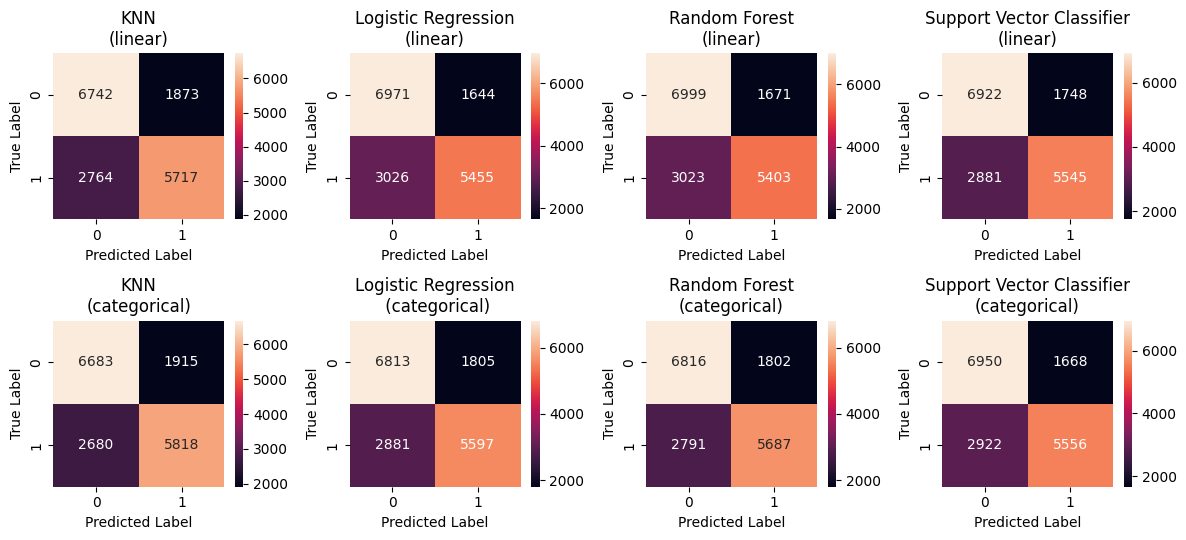

In [88]:
fig, ax = plt.subplots(2,4, figsize=(12,5.5))
sns.heatmap(cm_knn_df1, annot=True, fmt='d', ax=ax[0,0])
ax[0,0].set_title('KNN\n(linear)'), ax[0,0].set_xlabel('Predicted Label'), ax[0,0].set_ylabel('True Label')
sns.heatmap(cm_knn_df2, annot=True, fmt='d', ax=ax[1,0])
ax[1,0].set_title('KNN\n(categorical)'), ax[1,0].set_xlabel('Predicted Label'), ax[1,0].set_ylabel('True Label')

sns.heatmap(cm_log_df1, annot=True, fmt='d', ax=ax[0,1])
ax[0,1].set_title('Logistic Regression\n(linear)'), ax[0,1].set_xlabel('Predicted Label'), ax[0,1].set_ylabel('True Label')
sns.heatmap(cm_log_df2, annot=True, fmt='d', ax=ax[1,1])
ax[1,1].set_title('Logistic Regression\n (categorical)'), ax[1,1].set_xlabel('Predicted Label'), ax[1,1].set_ylabel('True Label')

sns.heatmap(cm_forest_df1, annot=True, fmt='d', ax=ax[0,2])
ax[0,2].set_title('Random Forest\n(linear)'), ax[0,2].set_xlabel('Predicted Label'), ax[0,2].set_ylabel('True Label')
sns.heatmap(cm_forest_df2, annot=True, fmt='d', ax=ax[1,2])
ax[1,2].set_title('Random Forest\n(categorical)'), ax[1,2].set_xlabel('Predicted Label'), ax[1,2].set_ylabel('True Label')

sns.heatmap(cm_svc_df1, annot=True, fmt='d', ax=ax[0,3])
ax[0,3].set_title('Support Vector Classifier\n(linear)'), ax[0,3].set_xlabel('Predicted Label'), ax[0,3].set_ylabel('True Label')
sns.heatmap(cm_svc_df2, annot=True, fmt='d', ax=ax[1,3])
ax[1,3].set_title('Support Vector Classifier\n(categorical)'), ax[1,3].set_xlabel('Predicted Label'), ax[1,3].set_ylabel('True Label')

plt.tight_layout()

#### Results
- None of the evaluated methods is excelling in predicting cardiovasculat disease. All of them have significant numbers of false positives and false negatives.
- Which algorithm is best? We are predicting cardiovascular disease, therefore it's important to keep false negatives at the lowest possible level. Based on this citeria, KNN (categorical) or Random Forest (categorical), were ususally the best ones.
- For KNN, the best fit is in the area of around 40-59. But it was also tested with number of neighbors ranging from 0 to 500 in steps of 20, to rule out that the best fit would be in 100+ area.
- All in all, KNN with categorical data and number of neighbors 59 was best model.

#### Discussion:

The ability to predict cardiovascular disease with these algorithms and the way it was done is not very good.
- There is too many false positives and false negatives.

Comparison of algorithms:
- I am surprised by the fact that the different tested algorithms perform so surprisingly equal results.

What variables could have been tweaked to improve the result?
- Feature engineering: removing less or more of the samples?
- Features used: finding a more optimal combination of features.
- Other algorithms: evaluating other algorithms such as Stochastic Gradient Descent. Could a clustering algorithm been used, to cluster into cardio==1 and cardio==0?
- Hyperparameter tuning: tuning other hyperparameters, per chosen algorithm.

Execution:
- Speed of execution was significantly improved when using "n_jobs=-1" in GridSearchCV, to allow all CPU power to be available for calculation.

Saving the model
- The model that is saved is Random Forest with n_estimators = 90 and max_depth = 7.
- This algorithm was the one that showed best results most frequently, of the tested algorithms.

In [96]:
import joblib

X, y = df2.drop(columns='cardio'), df2['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100)
test_samples = pd.concat([X_test, y_test], axis=1)
test_samples.to_csv("Lab_1_test_samples.csv", index=False)

#scaler = StandardScaler()
#pipe_knn = make_pipeline(scaler, KNeighborsClassifier())
param_grid_knn_best = {'kneighborsclassifier__n_neighbors': [59]}
classifier_knn_df2_best = GridSearchCV(estimator=pipe_knn, param_grid=param_grid_knn_best, cv=5, scoring='accuracy', n_jobs=-1)
classifier_knn_df2_best.fit(X2_train, y2_train)
y_pred_knn_best = classifier_knn_df2_best.predict(X_test)
#param_grid_forest_best = {'randomforestclassifier__n_estimators' : [90], 'randomforestclassifier__max_depth': [7]} # best hyperparameters
#classifier_forest_best = GridSearchCV(estimator=pipe_forest, param_grid=param_grid_forest_best, cv=5, scoring='accuracy', n_jobs=-1)
#classifier_forest_best.fit(X_train, y_train)
#y_pred_forest_best = classifier_forest_best.predict(X_test)
joblib.dump(classifier_knn_df2_best, 'Lab_1_production_model_knn.joblib', compress=3)

['Lab_1_production_model_knn.joblib']

In [ ]:
from joblib import dump # Save the models:
dump(classifier_svc_df1, 'Lab_1_production_model_svc_df1.joblib', compress=3)
dump(classifier_svc_df2, 'Lab_1_production_model_svc_df2.joblib', compress=3)

['Lab_1_production_model_svc_df2.joblib']